In [707]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")

In [708]:
def positionate(df_):
    df = df_.copy()
    res = df.apply(lambda row: [[row['Year'],data] for data in row['Raw_Data']], axis=1)
    rawdata = pd.DataFrame([i for sublist in res for i in sublist])
    rawdata.columns = ["Year", "Points"]
    t = map(list, zip(*df.Raw_Data)) 
    tt = map(list, zip(*t))
    test = df.apply(lambda row: [[i+1, data] for i, data in enumerate(row['Raw_Data'])], axis=1)
    test_ = pd.DataFrame([i for sublist in test for i in sublist])
    test_.columns = ["Rank", "Points"]
    return test_, pd.DataFrame(t).index+1, pd.DataFrame(tt).std(), pd.DataFrame(tt).mean()

def dict_to_parsed_df(d):
    data = []
    for k, v in d.iteritems():
        if v is not None:
            try:
                temp = dict_to_df(v)
                temp.Pts = temp.Pts.astype(int)
                data.append([k, gini_coeff(temp.Pts), temp.Pts.mean(), temp.Pts.std(), temp.Pts])
            except:
                print k
    df = pd.DataFrame(data)
    df.columns = ["Year", "Gini", "Mean", "Std", "Raw_Data"]
    df.sort('Year', inplace=True)
    return df.reset_index(drop=True)

def helper(df_):
    df = df_.copy()
    try:
        df['Team']
    except KeyError:
        for i, column in enumerate(df.columns):
            if len(column.split("Team")) > 1:
                df.insert(1, "Team", df.iloc[:,i], allow_duplicates=False)
                df.drop(column, 1, inplace=True)
    return df

def dict_to_df(v):
    try:
        temp = pd.DataFrame(v[1:], columns=v[0])
    except:
        temp = pd.DataFrame(v[1:], columns=v[0][1:])
        temp["Pos"] = range(1,len(temp)+1)
        cols = temp.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        temp = temp[cols]
    return helper(temp)

def gini_coeff(x):
    n = len(x)
    s = x.sum()
    r = np.argsort(np.argsort(-x))
    return 1 - (2.0 * (r*x).sum() + s)/(n*s)



In [709]:
def calc_gini(top):
    rest = [2*(19-top)]*(20-top)
    v = (6*(20-top))
    scores = [l+v for l in range(0, 6*top, 6)]+rest
    return gini_coeff(np.array(scores))

0.376966292135 0.35


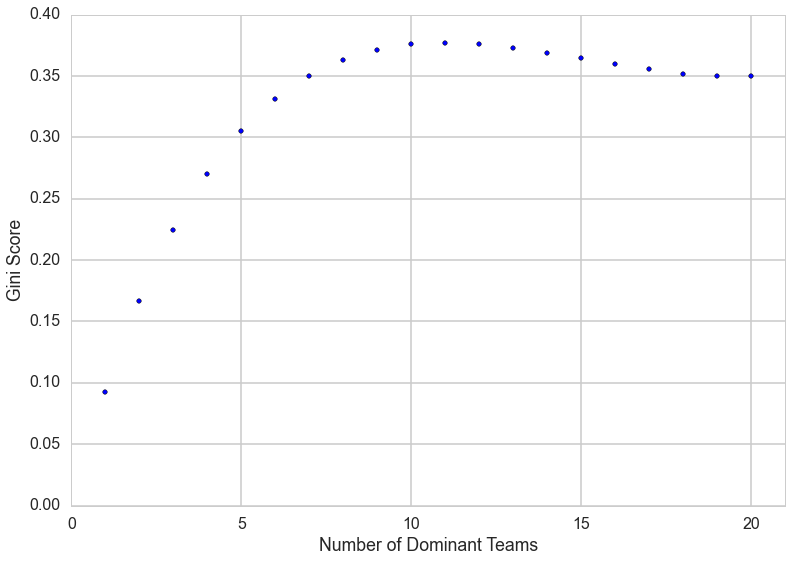

In [710]:
ginis = {top : (top, calc_gini(top)) for top in range(1,21)}
plt.scatter(ginis.keys(), zip(*ginis.values())[1])
plt.xlim(0,21)
plt.ylim(0,.4)
plt.ylabel("Gini Score")
plt.xlabel("Number of Dominant Teams");
print max(zip(*ginis.values())[1]), ginis[max(ginis.keys())][1]

In [711]:
with open('England_PL_tables.json', 'r') as fp:
    d = json.load(fp)

In [712]:
df = dict_to_parsed_df(d)
df.Year = df.Year.astype(int)

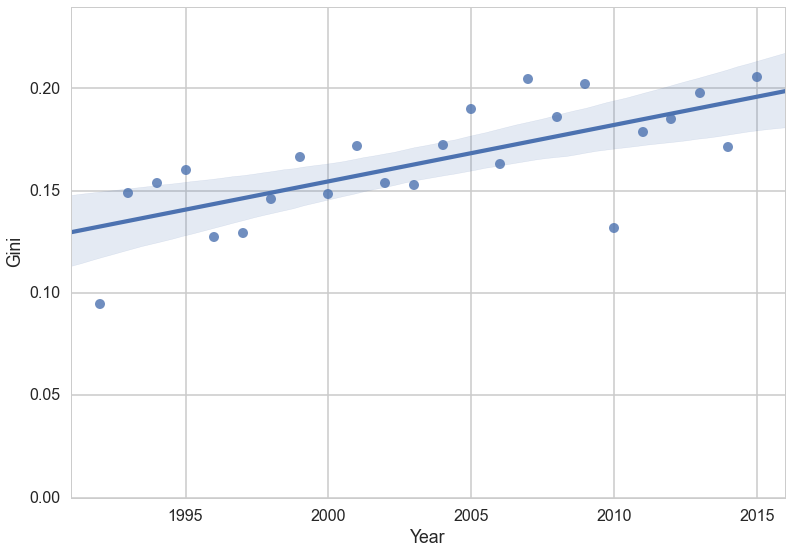

In [713]:
plt1 = sns.regplot(x = 'Year', y = 'Gini', data = df, scatter_kws={'s':100})
plt1.set_xlim(1991,2016)
plt1.set_ylim(0,.24);

In [714]:
res = df.apply(lambda row: [[row['Year'],data] for data in row['Raw_Data']], axis=1)
rawdata = pd.DataFrame([i for sublist in res for i in sublist])
rawdata.columns = ["Year", "Points"]

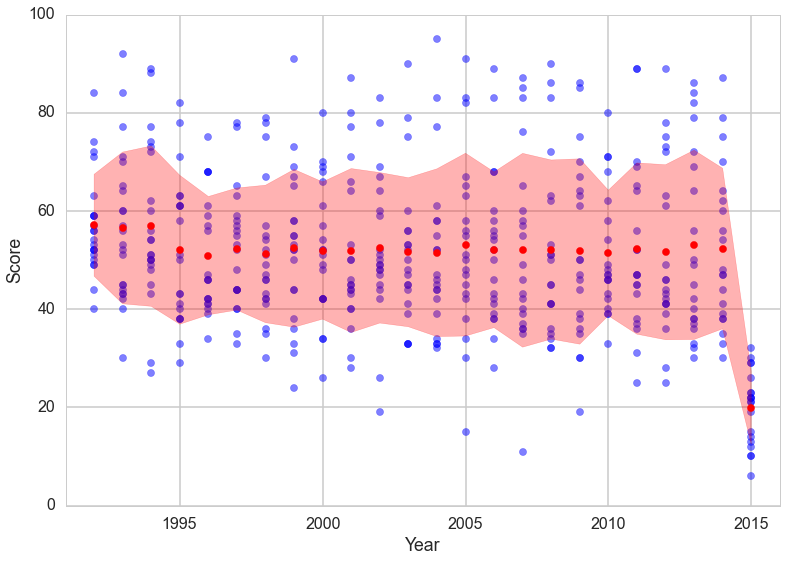

In [715]:
x = df.Year
y = df.Mean
std = df.Std
plt.scatter(x = rawdata['Year'], y = rawdata['Points'], color='b', alpha=.5, s=50)
plt.scatter(x = x, y = y,color='r', s = 50)
plt.fill_between(x, y-std, y+std, color='r', alpha=.3)
plt.ylim(0,100)
plt.xlim(1991,2016)
plt.ylabel('Score')
plt.xlabel('Year');

In [716]:
lm = smf.ols(formula='Year ~ Mean', data=df[3:-1]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Year   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sat, 05 Dec 2015   Prob (F-statistic):              0.217
Time:                        14:32:02   Log-Likelihood:                -62.547
No. Observations:                  20   AIC:                             129.1
Df Residuals:                      18   BIC:                             131.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1846.1933    123.613     14.935      0.000      1586.492  2105.895
Mean           3.0432      2.376      1.281      0.217        -1.949     8.035
==============================================================================
Omnibus:                        2.681   Durbin-Watson:                   0.260
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                1.169
Skew:                          -0.000   Prob(JB):                        0.557
Kurtosis:                       1.816   Cond. No.                     4.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [717]:
print df.Gini[3:11]
print df.Gini[-9:-1]
df.Gini[3:-1]

3     0.159885
4     0.127407
5     0.129522
6     0.145902
7     0.166317
8     0.148268
9     0.171944
10    0.154000
Name: Gini, dtype: float64
15    0.204615
16    0.185954
17    0.201981
18    0.131827
19    0.178653
20    0.184981
21    0.197552
22    0.171394
Name: Gini, dtype: float64


3     0.159885
4     0.127407
5     0.129522
6     0.145902
7     0.166317
8     0.148268
9     0.171944
10    0.154000
11    0.152810
12    0.172330
13    0.189699
14    0.163148
15    0.204615
16    0.185954
17    0.201981
18    0.131827
19    0.178653
20    0.184981
21    0.197552
22    0.171394
Name: Gini, dtype: float64

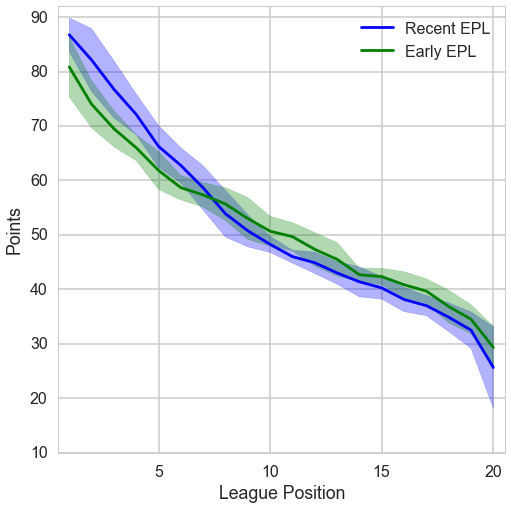

In [718]:
test_, pos, std, mean, = positionate(df[-9:-1])
test__, pos_, std_, mean_, = positionate(df[3:9])
#test___, pos__, std__, mean__, = positionate(df[9:15])
#pos = pd.DataFrame(tt).index+1
#std = pd.DataFrame(tt).std()
#mean = pd.DataFrame(tt).mean()
plt.figure(figsize=(8, 8))
#plt.scatter(x = test_['Rank'], y = test_['Points'], color='b', alpha=.5)
#plt.scatter(x = test__['Rank'], y = test__['Points'], color='g', alpha=.5)
#plt.scatter(x = test___['Rank'], y = test___['Points'], color='r', alpha=.5)
plt.plot(pos, mean, color='b', linestyle='-', label = "Recent EPL")
plt.plot(pos_, mean_, color='g', linestyle='-', label = "Early EPL")
#plt.plot(pos__, mean__, color='r', linestyle='-')
plt.fill_between(pos, mean-std, mean+std, color='b', alpha=.3)
plt.fill_between(pos_, mean_-std_, mean_+std_, color='g', alpha=.3)
plt.xlim([0.5,20.5])
plt.ylim([min(test_.Points)-1,max(test__.Points)+1]);
plt.xlabel('League Position')
plt.ylabel('Points')
plt.legend(frameon=False, loc='upper right')
#x_ = np.array(x)
#y_ = intercept + slope * x_
#plt.plot(x_, y_, 'r-');

In [719]:
#clhist_ = {'Year' : ['Champs', 'RunnerUp', 'Semis', 'Quarters', 'Sixteens', 'Group']}
#clhist = {k: "" for k in keys}

In [720]:
#clhist

In [721]:
def updateDict(d, array, verbose=False, limited=True):
    if len(array) != 7:
        raise ValueError("Need length of 7.  Format is Year, Champs, RunnerUp, Semis, Quarters, Sixteens, Group")
    else:
        d[array[0]] = list(array[1:])
    if verbose:
        limited = False
        temp = d.copy()
        del temp['Year']
        print temp
    if limited:
        print {array[0]: d.copy().pop(array[0])}

In [722]:
#vals = [2000,3,2,2,0,0,0]
#vals = [vals[0]]+vals[:0:-1]
#updateDict(clhist, vals)

In [723]:
def cldict_to_df(d):
    return pd.DataFrame([[k]+v for k, v in d.iteritems() if k != 'Year'], columns = ['Year']+d['Year'])

def transformList(lst):
    nlist = lst.copy()
    count = 0
    for i, v in enumerate(lst):
        if i > 1:
            nlist[i] = v-count
            count = count+nlist[i]
        elif i == 1:
            pass
        else:
            count = v + lst[i+1]
    return nlist

def scorereHelper(lst):
    nlst = transformList(lst)
    val = 0 
    weight = 1.
    for l in nlst:
        val = val + l*weight
        weight = weight/2
    return val

def clscorer(df):
    return pd.DataFrame(zip(df.Year ,df.apply(lambda x : scorereHelper(x[1:]), axis=1)), columns=['Year', 'Score'])

In [724]:
#cldf = cldict_to_df(clhist)

In [725]:
#cldf.to_json('CL_Res.json')

In [726]:
cldf = pd.read_json('CL_Res.json')

In [727]:
cldf

,Champs,Group,Quarters,RunnerUp,Semis,Sixteens,Year
0,0,3,2,0,0,2,2000
1,0,3,3,0,1,3,2001
10,0,4,2,0,0,3,2010
11,0,4,3,1,1,4,2011
12,1,4,1,0,1,2,2012
13,0,4,0,0,0,2,2013
14,0,4,2,0,1,4,2014
15,0,4,0,0,0,3,2015
2,0,3,2,0,1,3,2002
3,0,4,1,0,0,3,2003


In [728]:
cldf = cldf[['Year', 'Champs', 'RunnerUp', 'Semis', 'Quarters', 'Sixteens', 'Group']]
cldf.sort('Year', inplace=True)
cldf

,Year,Champs,RunnerUp,Semis,Quarters,Sixteens,Group
0,2000,0,0,0,2,2,3
1,2001,0,0,1,3,3,3
2,2002,0,0,1,2,3,3
3,2003,0,0,0,1,3,4
4,2004,0,0,1,2,3,3
5,2005,1,0,2,2,4,4
6,2006,0,1,1,1,3,4
7,2007,0,1,3,3,4,4
8,2008,1,1,3,4,4,4
9,2009,0,1,3,4,4,4


In [729]:
cldf_ = clscorer(cldf)

In [730]:
cldf_['Gini'] = np.array(df[-16:].Gini)

(1999, 2015)

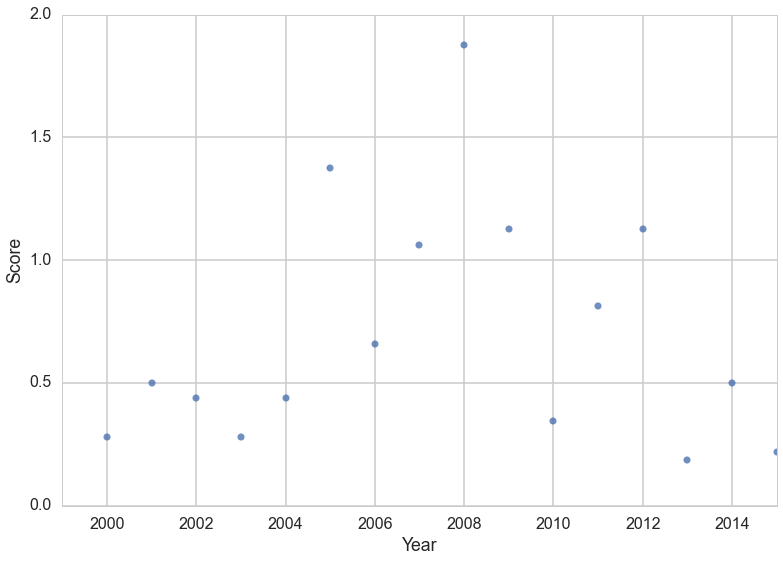

In [731]:
plt1 = sns.regplot(x = 'Year', y = 'Score', data = cldf_, fit_reg=False, scatter_kws={'s': 50})
plt1.set_xlim(1999, 2015)

In [732]:
cldf_

,Year,Score,Gini
0,2000,0.28125,0.148268
1,2001,0.50000,0.171944
2,2002,0.43750,0.154000
3,2003,0.28125,0.152810
4,2004,0.43750,0.172330
5,2005,1.37500,0.189699
6,2006,0.65625,0.163148
7,2007,1.06250,0.204615
8,2008,1.87500,0.185954
9,2009,1.12500,0.201981


In [733]:
smf.ols(formula = 'Gini ~ Score', data = cldf_).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gini   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     3.065
Date:                Sat, 05 Dec 2015   Prob (F-statistic):              0.102
Time:                        14:32:27   Log-Likelihood:                 40.581
No. Observations:                  16   AIC:                            -77.16
Df Residuals:                      14   BIC:                            -75.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1625      0.009     17.677      0.000         0.143     0.182
Score          0.0191      0.011      1.751      0.102        -0.004     0.042
==============================================================================
Omnibus:                        0.475   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.307
Skew:                           0.303   Prob(JB):                        0.858
Kurtosis:                       2.693   Cond. No.                         3.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [734]:
def temp(d):
    d_new = {}
    for year in d.keys():
        try:
            tempdf = d[year-1]
        except KeyError:
            print "Data not found for ", year-1
        else:
            d_new[year] = zip(helper(tempdf), helper(d[year]))
    return d_new


In [735]:
table_dict = {int(k): dict_to_df(v) for k, v in d.iteritems() if v is not None and int(k) != 2015}

In [736]:
l = []
for k, v in table_dict.iteritems():
    l = l+list(v['Team'])

In [741]:
dict_to_df(d['2015'])

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
0,1,Leicester City,15,9,5,1,32,21,+11,32,Qualification to Champions League group stage
1,2,Arsenal,15,9,3,3,27,13,+14,30,None
2,3,Manchester City,15,9,2,4,30,16,+14,29,None
3,4,Manchester United,15,8,5,2,20,10,+10,29,Qualification to Champions League play-off round
4,5,Tottenham Hotspur,15,6,8,1,25,12,+13,26,Qualification to Europa League group stage
5,6,West Ham United,15,6,5,4,25,21,+4,23,
6,7,Liverpool,14,6,5,3,18,15,+3,23,None
7,8,Crystal Palace,14,7,1,6,19,14,+5,22,None
8,9,Watford,15,6,4,5,17,16,+1,22,None
9,10,Stoke City,15,6,4,5,13,14,−1,22,None


In [745]:
translations = {v: v for v in np.unique(l)}

In [746]:
def scrubbed(d, splits = ['\\', '!', "("]):
    tpl = d.values()
    for s in splits:
        tpl = tuple([v.split(s)[0].rstrip() for v in tpl])
    tpl = np.unique(tpl)
    for k, v in d.iteritems():
        for t in tpl:
            if t in v:
                d[k] = t
    print "Scrubbed"
    return d
        
def parsed_dict(d, rigorous = False):
    translations = d.copy()
    again = True
    while again:
        values = np.unique(translations.values())
        init_len = len(values)
        for k, v in translations.iteritems():
            for val in values:
                if val in k:
                    try:
                        translations[k] = translations[val]
                    except KeyError:
                        translations[k] = val
        fin_len = len(np.unique(translations.values()))
        if init_len == fin_len:
            print "Compressed to", fin_len
            again = False
        else:
            print "Compressing from", init_len, "to", fin_len,"..."
    if rigorous:
        return parsed_dict(scrubbed(translations))
    else:
        return translations
    
def parse(a):
    return [translations_[t] for t in a]

In [747]:
translations_ = parsed_dict(translations, rigorous=True)

Compressing from 135 to 63 ...
Compressing from 63 to 54 ...
Compressed to 54
Scrubbed
Compressed to 46


In [748]:
np.unique(translations_.values())

array([u'Arsenal', u'Aston Villa', u'Barnsley', u'Birmingham City',
       u'Blackburn Rovers', u'Blackpool', u'Bolton Wanderers',
       u'Bradford City', u'Burnley', u'Cardiff City', u'Charlton Athletic',
       u'Chelsea', u'Coventry City', u'Crystal Palace', u'Derby County',
       u'Everton', u'Fulham', u'Hull City', u'Ipswich Town',
       u'Leeds United', u'Leicester City', u'Liverpool',
       u'Manchester City', u'Manchester United', u'Middlesbrough',
       u'Newcastle United', u'Norwich City', u'Nottingham Forest',
       u'Oldham Athletic', u'Portsmouth', u'Queens Park Rangers',
       u'Reading', u'Sheffield United', u'Sheffield Wednesday',
       u'Southampton', u'Stoke City', u'Sunderland', u'Swansea City',
       u'Swindon Town', u'Tottenham Hotspur', u'Watford',
       u'West Bromwich Albion', u'West Ham United', u'Wigan Athletic',
       u'Wimbledon', u'Wolverhampton Wanderers'], 
      dtype='<U23')

In [749]:
def translate(c1, c2, translations = translations_):
    c1_ = [translations_[s] for s in c1]
    c2_ = [translations_[t] for t in c2]
    d = {}
    for i, a in enumerate(c1_):
        if a not in c2_:
            d[a] = (i+1, len(c2_)+1)
        else:
            for i_, b in enumerate(c2_):
                if b in c1_:
                    if a == b:
                        d[a] = (i+1,i_+1)
                else:
                    d[b] = (len(c1_)+1, i_+1)
                    
    return d

In [750]:
def regressify(d, translations = translations_, years_past = 1, column = "Pos", twenty=True):
    out_d = {}
    for k, v in d.iteritems():
        text = "".join([str(k-years_past),"-",str(k)])
        try:
            df = d[k-years_past]
        except KeyError:
            print "Data doesn't exist for", text
        else:
            if df.shape[0] == 20 or (twenty == False):
                out_d[text] = translate(df.Team, d[k].Team, translations_)
            else:
                print "Excluding data from", text
    return out_d

In [751]:
def compile_everything(d, translations = translations_, years_past = 1, column = "Pos", twenty=True, s_ = 10):
    data = regressify(d, translations, years_past, column, twenty)
    xs = []
    ys = []
    count_dict = {}
    for year, v in data.iteritems():
        for team, (x, y) in v.iteritems():
            xs.append(x)
            ys.append(y)
            tup = (x, y)
            try:
                count_dict[tup]
            except KeyError:
                count_dict[tup] = [1, [(team, year)]]
            else:
                count_dict[tup][0] += 1
                count_dict[tup][1].append((team,year))

    regress_df = pd.DataFrame(zip(xs,ys), columns=["X", 'y'])
    xs_, ys_ = zip(*count_dict.keys())
    print "Sanity Check"
    print len(count_dict.values())
    print sum(zip(*count_dict.values())[0])
    print len(set(zip(xs,ys)))
    print len(xs), len(xs_)
    regression = smf.ols(formula = 'y ~ X', data = regress_df).fit()
    plt.scatter(xs_, ys_, s = [r*s_ for r in zip(*count_dict.values())[0]])
    plt.xlim(0,22)
    plt.ylim(0,22)
    plt.ylabel('Table Position in Year n')
    plt.title('How Well Does Table Position in Year N-%d Correspond to Performance in Year N' % years_past)
    plt.xlabel('Table Position in Year n-%d' % years_past)
    return regression, count_dict

Data doesn't exist for 1982-1992
Data doesn't exist for 1983-1993
Data doesn't exist for 1984-1994
Data doesn't exist for 1985-1995
Data doesn't exist for 1986-1996
Data doesn't exist for 1987-1997
Data doesn't exist for 1988-1998
Data doesn't exist for 1989-1999
Data doesn't exist for 1990-2000
Data doesn't exist for 1991-2001
Excluding data from 1992-2002
Excluding data from 1993-2003
Excluding data from 1994-2004
Sanity Check
124
284
124
284 124


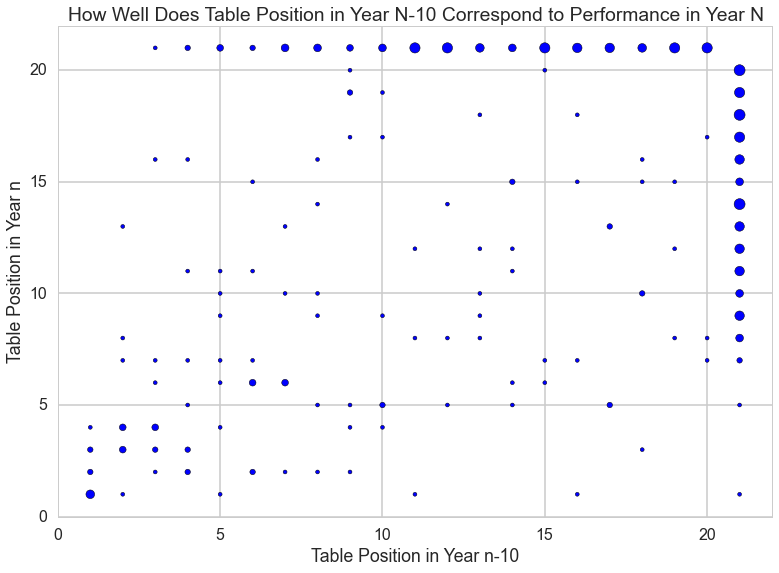

In [752]:
a,b = compile_everything(table_dict, years_past=10, s_ = 15);

In [753]:
b

{(1, 1): [5,
  [(u'Chelsea', '2004-2014'),
   (u'Manchester United', '2002-2012'),
   (u'Manchester United', '1998-2008'),
   (u'Manchester United', '2000-2010'),
   (u'Manchester United', '1996-2006')]],
 (1, 2): [2,
  [(u'Manchester United', '1999-2009'), (u'Manchester United', '1995-2005')]],
 (1, 3): [2, [(u'Arsenal', '1997-2007'), (u'Arsenal', '2001-2011')]],
 (1, 4): [1, [(u'Arsenal', '2003-2013')]],
 (2, 1): [1, [(u'Manchester United', '1997-2007')]],
 (2, 3): [3,
  [(u'Arsenal', '1999-2009'),
   (u'Arsenal', '2004-2014'),
   (u'Chelsea', '2003-2013')]],
 (2, 4): [3,
  [(u'Arsenal', '2002-2012'),
   (u'Arsenal', '1998-2008'),
   (u'Arsenal', '2000-2010')]],
 (2, 7): [1, [(u'Newcastle United', '1995-2005')]],
 (2, 8): [1, [(u'Liverpool', '2001-2011')]],
 (2, 13): [1, [(u'Newcastle United', '1996-2006')]],
 (3, 2): [1, [(u'Manchester United', '2001-2011')]],
 (3, 3): [2, [(u'Liverpool', '1995-2005'), (u'Chelsea', '1998-2008')]],
 (3, 4): [3,
  [(u'Liverpool', '1997-2007'),
   (u'M

In [754]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     49.36
Date:                Sat, 05 Dec 2015   Prob (F-statistic):           1.60e-11
Time:                        15:06:39   Log-Likelihood:                -924.91
No. Observations:                 284   AIC:                             1854.
Df Residuals:                     282   BIC:                             1861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.3544      0.836      9.995      0.000         6.709    10.000
X              0.3860      0.055      7.026      0.000         0.278     0.494
==============================================================================
Omnibus:                      153.006   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.127
Skew:                           0.012   Prob(JB):                     0.000191
Kurtosis:                       1.797   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [763]:
%%time
%%capture
pval_dict = {}
for y in range (1,30):
    try:
        val = compile_everything(table_dict, years_past=y)[0].pvalues
    except ValueError:
        break
    else:
        pval_dict[y] = val

Wall time: 738 ms


In [764]:
np.log(zip(*pval_dict.values())[1])

array([-176.34778368, -114.74097342,  -80.25983041,  -64.58947866,
        -48.51878256,  -42.66358359,  -35.45639567,  -28.25714346,
        -26.58621145,  -24.85872235,  -20.15122047,  -16.61797851,
        -10.34196403,   -8.62211346,   -7.73595166,   -4.87580611,
         -4.21975887,   -3.73024801,   -1.29312329])

In [766]:
pval_dict.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

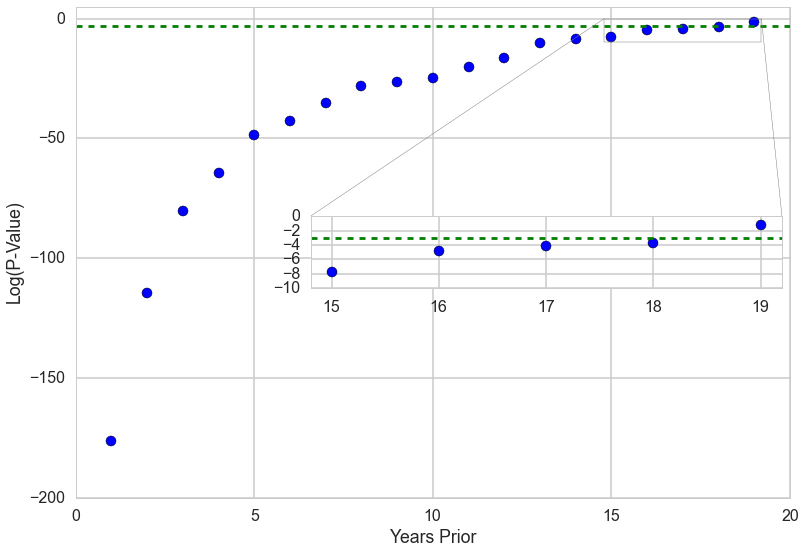

In [805]:
fig, ax = plt.subplots()
plt.axhline(y = np.log(.05), c = 'g', linestyle = 'dashed')
plt.scatter(y = np.log(zip(*pval_dict.values())[1]), x = pval_dict.keys(), s = 100, c = 'b')
plt.ylim([-200,5])
plt.xlabel('Years Prior')
plt.ylabel('Log(P-Value)');


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 3, loc=5)
plt.axhline(y = np.log(.05), c = 'g', linestyle = 'dashed')
plt.scatter(y = np.log(zip(*pval_dict.values())[1]), x = pval_dict.keys(), s = 100, c = 'b')
axins.set_xlim(14.8, 19.2) # apply the x-limits
axins.set_ylim(-10, 0)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5");


In [757]:
from itertools import product, combinations

In [758]:
cards = [p for p in product([1,2,3,4,5,6,7,10,11,12], [0,1,2,3])]
print len(cards)

40


In [759]:
from random import sample

In [359]:
draw = sample(cards, 4)
show = draw[0]
hand = draw[1:]

In [360]:
print show, hand

(4, 3) [(10, 2), (5, 3), (10, 3)]


In [362]:
if show[0] in [2,4,5,11,10]:
    print 12
else:
    print "no"

12


In [367]:
def score(c):
    if c>=10:
        return 0
    else:
        return c

In [369]:
def piece(c, show, envy = True):
    d = {2:30,4:29,5:28,11:27,10:27}
    pieces = [2,4,5,11,10]
    if c[0] in pieces and c[1] == show[1]:
        if envy:
            return d[c[0]]
        else:
            return True
    elif show[0] in [2,4,5,11,10] and c[0] == 12 and c[1] == show[1]:
        if envy:
            return d[show[0]]
        else:
            return True
    else:
        if envy:
            return score(c[0])
        else:
            return False

In [388]:
len(set([0,1,1]))

2

In [407]:
def flower(hand,show):
    pieces = sum([piece(h, show, envy=False) for h in hand])
    if pieces == 0:
        suits = len(set([suit for val, suit in hand]))
        if suits == 1:
            return True
        else:
            return False
    elif pieces == 1:
        suits = len(set([c[1] for c in hand if piece(c, show, envy=False) == False]))
        if suits == 1:
            return True
        else:
            return False
    else:
        return True

In [417]:
hand

[(12, 3), (6, 2), (1, 1)]

In [418]:
show

(2, 2)

In [416]:
flower(hand, show)

False

In [415]:
draw = sample(cards, 4)
show = draw[0]
hand = draw[1:]

In [384]:
def scorer(c1, c2, show):
    p1 = piece(c1, show, envy = False)
    p2 = piece(c2, show, envy = False)
    if p1 or p2:
        return piece(c1, show) + piece(c2, show)
    else:
        if c1[1] == c2[1]:
            return 20+score(c1[0]) + score(c2[0])
        else:
            return score(c1[0]) + score(c2[0])

In [474]:
%%time
nsims = 10
vals = [0] * nsims
for i in range(nsims):
    draw = sample(cards, 4)
    show = draw[0]
    hand = draw[1:]
    try:
        vals[i] = max([scorer(c1, c2, show) for c1, c2 in combinations(hand, 2) if flower(hand, show) == False])
    except ValueError:
        vals[i] = -1
    
final = [item for item in vals if item >= 0]

(12, 0) [(10, 1), (6, 0), (5, 0)]
(11, 2) [(3, 2), (7, 0), (3, 1)]
(11, 3) [(11, 2), (1, 3), (2, 0)]
(4, 2) [(11, 1), (12, 2), (6, 2)]
(3, 3) [(7, 3), (5, 1), (3, 0)]
(6, 3) [(1, 0), (5, 3), (2, 1)]
(2, 1) [(10, 0), (4, 2), (1, 0)]
(2, 2) [(4, 3), (7, 2), (3, 1)]
(2, 2) [(2, 0), (5, 3), (1, 2)]
(5, 1) [(4, 3), (2, 2), (11, 3)]
[34, 10, 3, 35, 12, 30, 21, 11, 7, 24]
Wall time: 0 ns


In [ ]:
print len(final)/float(nsims)
print sum(final) / float(len(final))
print sumlen()

In [546]:
def simmer(nsims, deck, players):
    vals = [0] * nsims
    for i in range(nsims):
        draw = sample(cards, 1+3*players)
        show = draw[0]
        hand1 = draw[1:4]
        hand2 = draw[4:7]
        hand3 = draw[7:10]
        hand4 = draw[10:13]
        #hand5 = draw[13:16]
        #hand6 = draw[16:]
        try:
            envies = []
            for p in range(players):
                hand = draw[1+3*p:1+3*(p+1)]
                envies.append((max([scorer(c1, c2, show) for c1, c2 in combinations(hand, 2) if flower(hand, show) == False]),p))
            vals[i] = envies
        except ValueError:
            vals[i] = -1
    final = [item for item in vals if item != -1]
    return final

def parse_truco(v):
    d = {}
    for h in v:
        place = h[0]
        ind = h[1]
        try:
            d[place].append(ind)
        except KeyError:
            d[place] = [ind]
    return d    

In [613]:
if 3:
    print "Hey"
else:
    print "NEy"

Hey


In [622]:
for e in four_people[:100]:

    print t1_m, t2_m

5 30
25 32
31 27
31 27
31 35
35 32
29 27
31.98 34.99
30.98 32.97
34 10
22 29
27.96 25.97
6.98 24.99
29 26
33 36
27 36
33 23
35 20
28 22
26 31
36 33
27.96 29.97
31 25
28 33
34 30
32 28
30 23
32 29
25 27
37 29
13 27
33 27
11 34
26 20
29 34
29 23
33 35
28 29
31 36
30 34
30.96 30.97
34 27
24 30
30.96 26.99
31 35
7 36
27.98 28.97
26.98 23.99
30 33
32 31
32 33
36 26
12 34
29.98 21.97
32 36
36.98 12.99
21 29
32 29
36.98 30.99
22.98 30.99
21 26
8.96 29.97
29 34
35 24
26 33
30 35
35 14
33 25
21 31
19.98 20.99
28 8
23 30
27 25
5 23
24.98 24.99
37 12
30 27
32.96 29.99
33 34
7.98 32.97
31 34
35.96 35.97
25.98 25.99
27 33
23 28
21 35
32 35
34 29
34 27
27 32
34 33
25 30
20 35
33 6
31 33
24 25
32.98 26.99
13 34
32.98 21.97
27 21


In [703]:
def sims_to_dict(envies, summary = False):
    d = {}
    for e in envies:
        if len(set(zip(*e)[0])) != 4:
            e_new = [(p-(i+1)/float(100),i) for p, i in e]
        else:
            e_new = e
        t1_m = 0
        t2_m = 0
        for e_, i in e_new:
            if i % 2 and e_ > t1_m:
                t1_m = e_
            elif (i % 2 == 0) and e_ > t2_m: 
                t2_m = e_
        for e_, i in e_new:
            ind = 0
            if i % 2 and e_ > t2_m:
                ind = 1
            elif (i % 2 == 0) and e_ > t1_m:
                ind = 1
            try:
                d[int(round(e_))].append((i, ind))
            except KeyError:
                d[int(round(e_))] = [(i, ind)]
    d_ = {}
    for k, v in d.iteritems():
        d_[k] = parse_truco(v)
    if summary:
        return {k : {k_ : (sum(v_)/float(len(v_)), len(v_)) for k_, v_ in v.iteritems()} for k, v in d_.iteritems()}
    else:
        return d_

In [601]:
%%time
nsims = 1000000
four_people = simmer(nsims, cards, 4)
six_people = simmer(nsims, cards, 4)
print 1-len(four_people)/float(nsims)
print 1-len(six_people)/float(nsims)

0.500589
0.500546
Wall time: 3min 4s


In [704]:
%%time
d_four = sims_to_dict(four_people, summary=True)
d_four_ = sims_to_dict(four_people)
d_six = sims_to_dict(four_people, summary=True)
d_six_ = sims_to_dict(six_people)

Wall time: 13.7 s


In [705]:
d_four

{0: {0: (0.0, 2435), 1: (0.0, 2386), 2: (0.0, 2289), 3: (0.0, 2416)},
 1: {0: (0.0, 3738), 1: (0.0, 3714), 2: (0.0, 3791), 3: (0.0, 3653)},
 2: {0: (0.0, 4028),
  1: (0.0, 4154),
  2: (0.0, 4079),
  3: (0.0002462447672986949, 4061)},
 3: {0: (0.0004580152671755725, 6550),
  1: (0.0007633587786259542, 6550),
  2: (0.0, 6558),
  3: (0.00015360983102918587, 6510)},
 4: {0: (0.0019289060347203086, 7258),
  1: (0.0012367733956300674, 7277),
  2: (0.0008186655751125665, 7329),
  3: (0.0004187604690117253, 7164)},
 5: {0: (0.003371308997907463, 8602),
  1: (0.002179648961798784, 8717),
  2: (0.002437891804039935, 8614),
  3: (0.0017411491584445734, 8615)},
 6: {0: (0.0049521571260701695, 11914),
  1: (0.0034485659012532593, 11889),
  2: (0.0033545790003354577, 11924),
  3: (0.002809227887971397, 11747)},
 7: {0: (0.011482326900463443, 14457),
  1: (0.0072017173325946955, 14441),
  2: (0.00811275352354761, 14545),
  3: (0.004792998055015282, 14396)},
 8: {0: (0.018079259473531964, 13828),
  1:

In [706]:
d_six

{0: {0: (0.0, 2435), 1: (0.0, 2386), 2: (0.0, 2289), 3: (0.0, 2416)},
 1: {0: (0.0, 3738), 1: (0.0, 3714), 2: (0.0, 3791), 3: (0.0, 3653)},
 2: {0: (0.0, 4028),
  1: (0.0, 4154),
  2: (0.0, 4079),
  3: (0.0002462447672986949, 4061)},
 3: {0: (0.0004580152671755725, 6550),
  1: (0.0007633587786259542, 6550),
  2: (0.0, 6558),
  3: (0.00015360983102918587, 6510)},
 4: {0: (0.0019289060347203086, 7258),
  1: (0.0012367733956300674, 7277),
  2: (0.0008186655751125665, 7329),
  3: (0.0004187604690117253, 7164)},
 5: {0: (0.003371308997907463, 8602),
  1: (0.002179648961798784, 8717),
  2: (0.002437891804039935, 8614),
  3: (0.0017411491584445734, 8615)},
 6: {0: (0.0049521571260701695, 11914),
  1: (0.0034485659012532593, 11889),
  2: (0.0033545790003354577, 11924),
  3: (0.002809227887971397, 11747)},
 7: {0: (0.011482326900463443, 14457),
  1: (0.0072017173325946955, 14441),
  2: (0.00811275352354761, 14545),
  3: (0.004792998055015282, 14396)},
 8: {0: (0.018079259473531964, 13828),
  1:

In [697]:
hist_4 = {k : sum([len(v_) for _, v_ in v.iteritems()])/float(nsims) for k, v in d_four_.iteritems()}
#hist_4

In [698]:
hist_6 = {k : sum([len(v__) for _, v__ in v.iteritems()])/float(nsims) for k, v in d_six_.iteritems()}
#hist_6

(-0.5, 37.5)

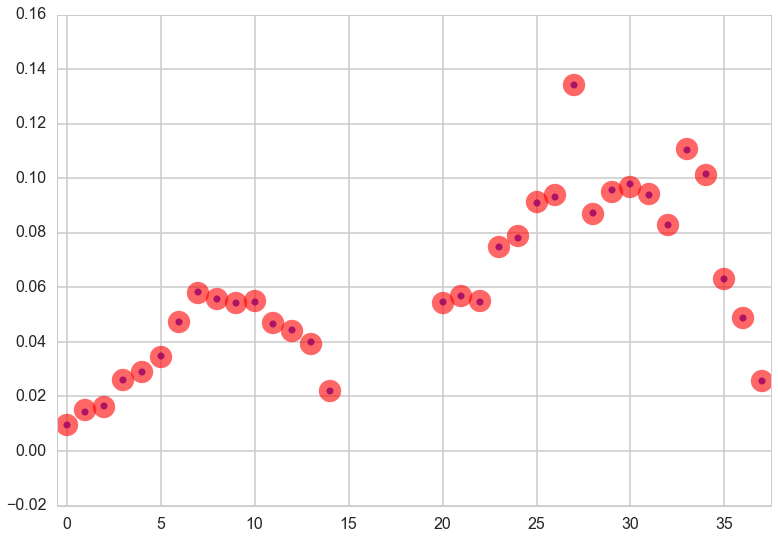

In [696]:
sns.regplot(y = np.array(hist_6.values()), x = np.array(hist_6.keys()), fit_reg=False, scatter_kws={'s' : 50, 'color' : 'b'})
sns.regplot(y = np.array(hist_4.values()), x = np.array(hist_4.keys()), fit_reg=False, scatter_kws={'s' : 500, 'color' : 'r', 'alpha' : .6})
plt.xlim([-.5, 37.5])

In [689]:
np.array(hist_6.values()) - np.array(hist_4.values())

array([  2.20000000e-05,  -4.39000000e-04,   1.47000000e-04,
         5.10000000e-05,  -3.50000000e-05,   3.77000000e-04,
        -2.66000000e-04,   3.07000000e-04,   9.20000000e-05,
         6.20000000e-05,  -2.89000000e-04,  -2.07000000e-04,
         3.02000000e-04,   7.52000000e-04,  -8.60000000e-05,
         2.73000000e-04,  -6.90000000e-05,  -4.12000000e-04,
        -1.12000000e-04,  -6.49000000e-04,  -3.77000000e-04,
        -6.21000000e-04,   1.32000000e-04,   2.54000000e-04,
         4.24000000e-04,   9.53000000e-04,  -3.15000000e-04,
         1.56000000e-04,  -1.70000000e-04,   7.60000000e-05,
         4.00000000e-06,  -1.32000000e-04,  -3.30000000e-05])